# Testing ANTSPy against ANTS + Nibabel 

In [34]:
import os
import sys
module_path = os.path.abspath(os.path.join('../utils/'))
if module_path not in sys.path:
    sys.path.append(module_path)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from deepbrain import Extractor

from utils.skull_stripping_ants.s3 import *

# %load_ext autoreload
# %autoreload 2

In [35]:
def show_slices(slices,img):
    """ Function to display row of image slices """
    fig, axes = plt.subplots(1, len(slices))
    fig.set_size_inches(11,8)
    for i, slice in enumerate(slices):

        axes[i].imshow(slice.T, cmap="gray", origin="lower")
    plt.suptitle(f"Center slices for current MRI image \n Image size: {img.shape}",fontsize=20)
    # print("image size:",img.shape)
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.20)
    plt.show()

def show_brain_center_slice(img: np.memmap):
    slice_0 = img[int(img.shape[0]/2), :, :]
    slice_1 = img[:, int(img.shape[1]/2), :]
    slice_2 = img[:, :, int(img.shape[2]/2)]
    show_slices([slice_0, slice_1, slice_2],img)

# img_stripped = img.copy()
# img_stripped[~mask] = 0

In [36]:
def execute_skull_stripping_process(input_path,output_path,skull_stripping_type = 'ANTs'):
    
    set_env_variables()
    start = time.time()

    images_to_process,_,_ = list_available_images(input_path)
    print('------------------------------------------------------------------------------------')
    print(f"Starting {skull_stripping_type} skull stripping process for {len(images_to_process)} images. This might take a while... =)")
    print('------------------------------------------------------------------------------------')
    
    for ii,image_path in enumerate(images_to_process):
        print('\n------------------------------------------------------------------------------------')
        print(f"Processing image ({ii+1}/{len(images_to_process)}):",image_path)
        
        if skull_stripping_type == 'ANTs':
            apply_ants_skull_stripping_to_mri(image_path,output_path)
            print("Deleting useless images (masks, gm,wm, etc)...\n")
            delete_useless_images(output_path)
        elif skull_stripping_type == 'DeepBrain':
            apply_deep_brain_skull_stripping_to_mri(image_path,output_path)
        else:
            raise('Please select a valid skull stripping process.')

    total_time = (time.time() - start) / 60.
    print('-------------------------------------------------------------')
    print('-------------------------------------------------------------')
    print('-------------------------------------------------------------')
    print('All images processed! Process took %.2f min) \n' % total_time)
    print('-------------------------------------------------------------')
    print('-------------------------------------------------------------')
    print('-------------------------------------------------------------')

def list_available_images(input_dir):
    
    '''
    List full path to available images.
    '''

    available_images = []
    print("Looking for MRI raw images in path:",input_dir,'\n')
    
    available_images = list(Path(input_dir).rglob("*.nii"))
    print("Found a total of ",len(available_images)," images.")

    masks_and_wrong_images = list(Path(input_dir).rglob("*[Mm]ask*.nii"))
    print("Found a total of ",len(masks_and_wrong_images)," mask images.")
    
    print("Available images to process: ",len(available_images) - len(masks_and_wrong_images),"\n")
    selected_images = list(set(available_images) - set(masks_and_wrong_images))
    
    return selected_images,available_images,masks_and_wrong_images

def delete_useless_images(input_dir):
    
    available_images = [os.fspath(x) for x in list(Path(input_dir).rglob("*.nii.gz"))]
    if available_images:
        useless_images = [x for x in available_images \
            if "masked_basic" in x \
            or "wm" in x \
            or "gm" in x \
            or "csf" in x \
            or "mask_" in x \
            or "mask." in x ]
        for img in useless_images:
            os.remove(img)

def apply_ants_skull_stripping_to_mri(input_path,output_path):
    if not os.path.exists(output_path):
        print("Creating output path... \n")
        os.makedirs(output_path)

    start = time.time()
    skull_stripper = SkullStripper(input_path, output_path, want_tissues=False, want_atlas=False)
    output_img_path = skull_stripper.strip_skull()
    total_time = (time.time() - start) / 60.
    print('Done with skull stripping! Process took %.2f min) \n' % total_time)

def apply_deep_brain_skull_stripping_to_mri(input_path,output_path,probability = 0.5):
    global_input = input_path
    if not os.path.exists(output_path):
        print("Creating output path... \n")
        os.makedirs(output_path)
    
    start = time.time()
    # load img
    # TODO: maybe replace with antspy because it is faster
    img = nib.load(input_path).get_fdata()

    # execute brain extraction
    ext = Extractor()
    print("Running DeepBrain Skull Stripping...")
    prob = ext.run(img) 
    mask = prob > probability
    
    # apply mask
    final_img = img.copy()
    final_img[~mask] = 0
    final_img_name = os.path.splitext(os.path.splitext(os.path.basename(input_path))[0])[0]
    output_file_path = output_path + '/' + final_img_name + "_masked_deepbrain.nii.gz"
    
    final_img_nii = nib.Nifti1Image(final_img, np.eye(4))
    final_img_nii.header.get_xyzt_units()
    final_img_nii.to_filename(output_file_path)
    print('Skull stripped image saved as :',output_file_path)

    total_time = (time.time() - start)
    print('Done with skull stripping! Process took %.2f sec) \n' % total_time)
    # return final_img

def set_env_variables():
    print("Setting ANTs and NiftyReg environment variables...\n")

    os.environ['ANTSPATH'] = '/home/lucasthim1/ants/ants_install/bin'
    os.environ['PATH'] =os.environ['PATH'] +  ":" + os.environ['ANTSPATH']
    os.environ['NIFTYREG_INSTALL'] = '/home/lucasthim1/niftyreg/niftyreg_install'
    os.environ['PATH'] = os.environ['PATH'] +  ":" + os.environ['NIFTYREG_INSTALL'] + '/bin'


# Comparing Results from Early methods

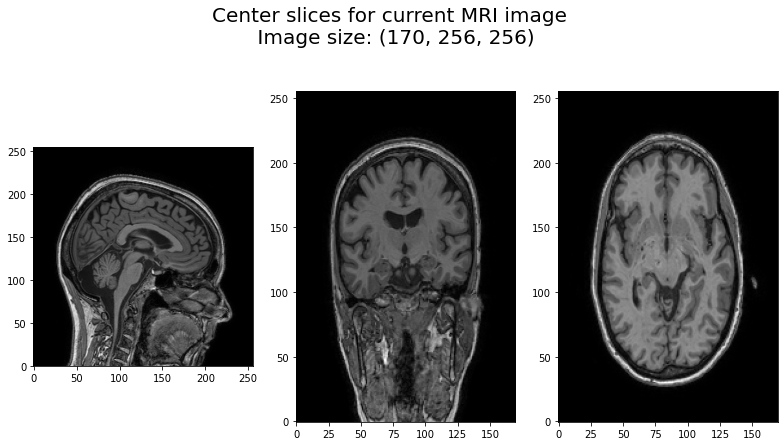

In [27]:
input_path = '/home/lucasthim1/alzheimer_data/test/002_S_4270/MT1__N3m/2011-10-11_07_59_12.0/S125083/ADNI_002_S_4270_MR_MT1__N3m_Br_20111015081648646_S125083_I261073.nii'
img = nib.load(input_path).get_fdata()
show_brain_center_slice(img)

## Skull stripped image with Deep Brain (.nii.gz)

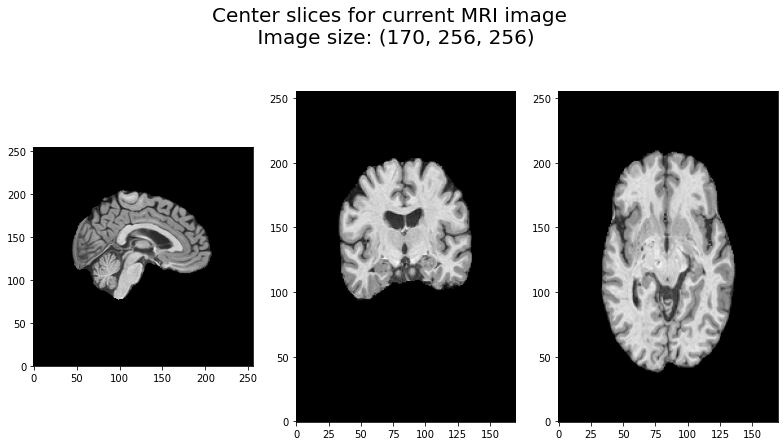

In [28]:
input_path = '/home/lucasthim1/alzheimer_data/test/ADNI_002_S_4270_MR_MT1__N3m_Br_20111015081648646_S125083_I261073_masked_deepbrain.nii.gz'
img = nib.load(input_path).get_fdata()
show_brain_center_slice(img)

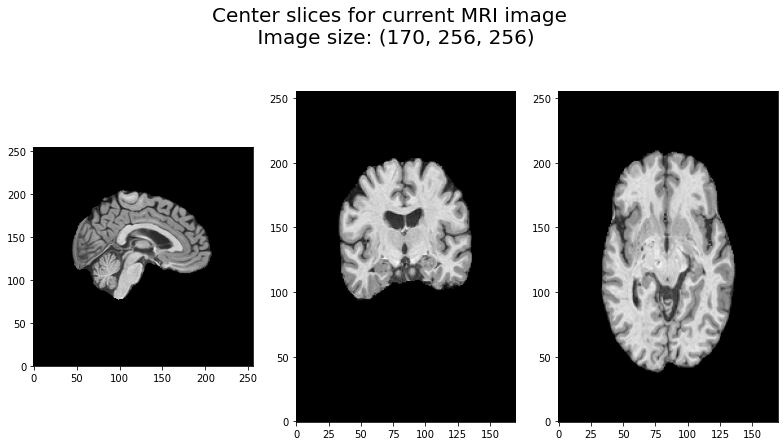

In [32]:
input_path = '/home/lucasthim1/alzheimer_data/test/002_S_4270/ADNI_002_S_4270_MR_MT1__N3m_Br_20111015081648646_S125083_I261073_masked_deepbrain.nii.gz'
img = nib.load(input_path).get_fdata()
show_brain_center_slice(img)

## Skull stripped and registered image with ANTs (.nii.gz)

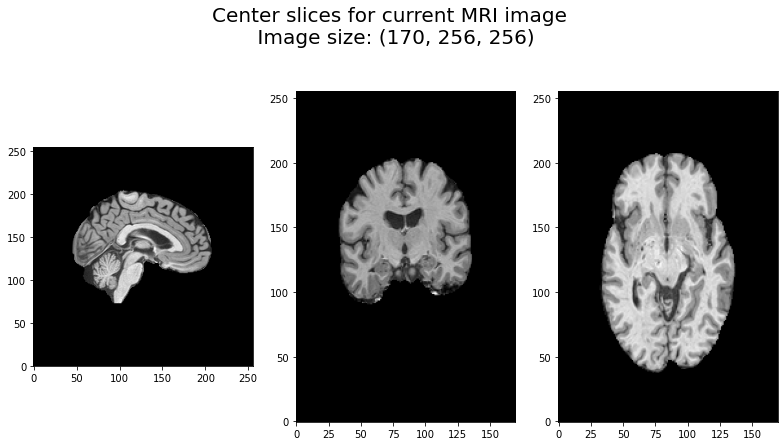

In [30]:
input_path = '/home/lucasthim1/alzheimer_data/test/ADNI_002_S_4270_MR_MT1__N3m_Br_20111015081648646_S125083_I261073_masked.nii.gz'
img = nib.load(input_path).get_fdata()
show_brain_center_slice(img)

# Building S3 pre processing pipeline

In [21]:

def apply_full_s3_skull_stripping(input_path,output_path):
    if not os.path.exists(output_path):
        print("Creating output path... \n")
        os.makedirs(output_path)

    start = time.time()
    skull_stripper = SkullStripper(input_path, output_path, want_tissues=False, want_atlas=False)
    skull_stripper.strip_skull()
    total_time = (time.time() - start) / 60.
    print('Done! Process took %.2f min)' % total_time)

def apply_skull_stripping(input_path, output_path,type = 'simple'):
    '''
    Skull Stripping Registration procedure for MRI data.

    Arguments:

    input_path: input path of the image to be registered
    
    output_path: output directory to save the registered image

    type: registration type. Values can be ['rigid_refined','affine_refined','simple']
    '''

    input_path = os.path.abspath(input_path)
    if output_path is None:
        output_path = os.path.dirname(os.path.abspath(input_path))
    if not os.path.exists(output_path):
        print("Creating output path... \n")
        os.makedirs(output_path)
    output_path = os.path.abspath(output_path)
    
    start = time.time()
    skull_stripper = SkullStripper(input_path, output_path, want_tissues=True, want_atlas=False)
    if type == 'affine_refined':
        print("Executing Affine Registration... \n")
        skull_stripper.strip_skull()
    elif type == 'rigid_refined':
        print("Executing Rigid Registration... \n")
        skull_stripper.rigid_strip_skull()
    elif type == 'simple':
        print("Executing Simple Rigid Registration... \n")
        skull_stripper.simple_strip_skull()
    elif type == 'test':
        print("Executing Test Registration... \n")
        skull_stripper.test_strip_skull()
    else:
        raise Exception("Please select a valid type of skull stripping registration: ['rigid_refined','affine_refined','simple']")

    print('Done! Process took %.2f min)' % ((time.time() - start) / 60.))
    

In [22]:
set_env_variables()

Setting ANTs and NiftyReg environment variables...



In [5]:
main_dir = '/home/lucasthim1/alzheimer_data/test/002_S_4270/'

## Checking image and masks - Patient 002_S_4225

### Raw image

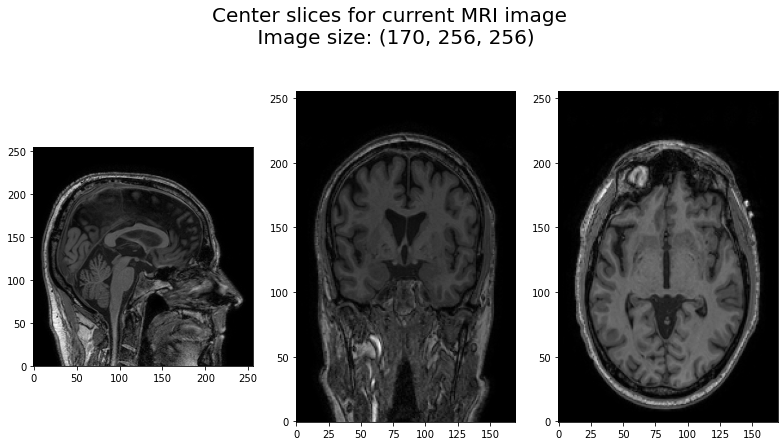

In [6]:
input_path = main_dir + "002_S_4225/MT1__N3m/2011-09-21_10_09_36.0/S122881/ADNI_002_S_4225_MR_MT1__N3m_Br_20110928092836722_S122881_I258686.nii"
img = nib.load(input_path).get_fdata()
show_brain_center_slice(img)

### Complete Affine Transformation with tissue segmentation overlay for better accuracy

In [8]:
input_path = main_dir + "002_S_4225/MT1__N3m/2011-09-21_10_09_36.0/S122881/ADNI_002_S_4225_MR_MT1__N3m_Br_20110928092836722_S122881_I258686.nii"
output_path = main_dir + "/Registered/002_S_4225_affine"
apply_skull_stripping(input_path,output_path,type='affine_refined')

Executing Affine Registration... 

Skull stripping started. 
 --------------------------- 

Input Modality: /home/lucasthim1/mmml-alzheimer-diagnosis/src/data/ADNI/002_S_4225/MT1__N3m/2011-09-21_10_09_36.0/S122881/ADNI_002_S_4225_MR_MT1__N3m_Br_20110928092836722_S122881_I258686.nii 

Output Folder : /home/lucasthim1/mmml-alzheimer-diagnosis/src/data/ADNI/Registered/002_S_4225_affine 


Compute basic mask: 
 -----------------

 Deformable tissue registration started 
 -----------------
csf image is saved to: /home/lucasthim1/mmml-alzheimer-diagnosis/src/data/ADNI/Registered/002_S_4225_affine/ADNI_002_S_4225_MR_MT1__N3m_Br_20110928092836722_S122881_I258686_csf.nii.gz
gm image is saved to: /home/lucasthim1/mmml-alzheimer-diagnosis/src/data/ADNI/Registered/002_S_4225_affine/ADNI_002_S_4225_MR_MT1__N3m_Br_20110928092836722_S122881_I258686_gm.nii.gz
wm image is saved to: /home/lucasthim1/mmml-alzheimer-diagnosis/src/data/ADNI/Registered/002_S_4225_affine/ADNI_002_S_4225_MR_MT1__N3m_Br_201109

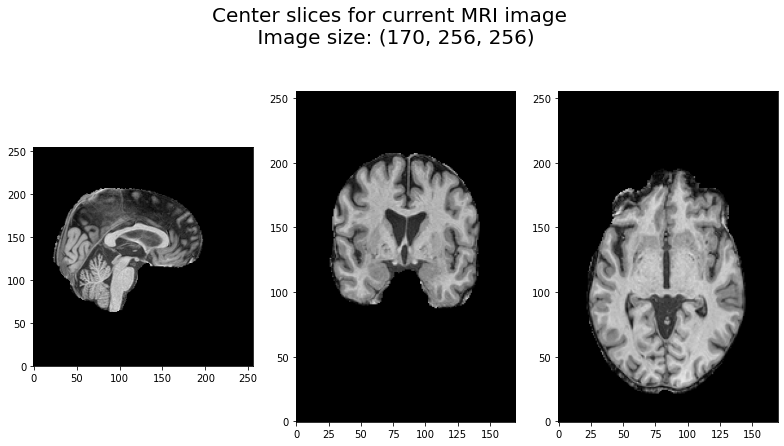

In [9]:
refined_mask_path = '/home/lucasthim1/mmml-alzheimer-diagnosis/src/data/ADNI/Registered/002_S_4225_affine/ADNI_002_S_4225_MR_MT1__N3m_Br_20110928092836722_S122881_I258686_masked_basic.nii.gz'
mask_img = nib.load(refined_mask_path).get_fdata()
show_brain_center_slice(mask_img)

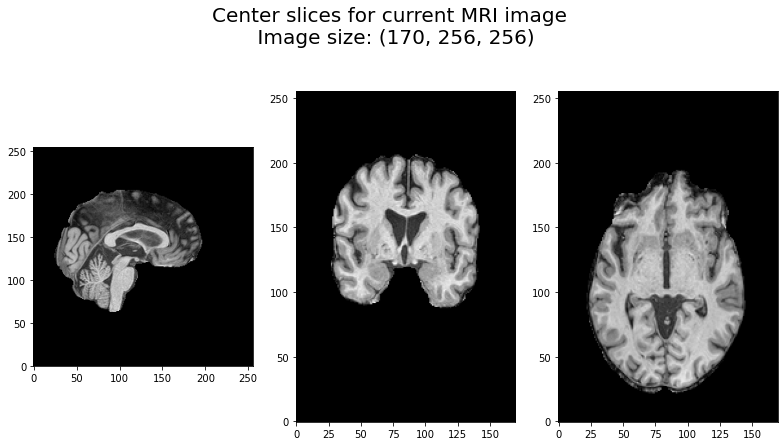

In [10]:
refined_mask_path = '/home/lucasthim1/mmml-alzheimer-diagnosis/src/data/ADNI/Registered/002_S_4225_affine/ADNI_002_S_4225_MR_MT1__N3m_Br_20110928092836722_S122881_I258686_masked.nii.gz'
mask_img = nib.load(refined_mask_path).get_fdata()
show_brain_center_slice(mask_img)

### Test Registration

In [7]:
input_path = main_dir + "002_S_4225/MT1__N3m/2011-09-21_10_09_36.0/S122881/ADNI_002_S_4225_MR_MT1__N3m_Br_20110928092836722_S122881_I258686.nii"
output_path = main_dir + "/Registered/002_S_4225_test"
apply_skull_stripping(input_path,output_path,type='test')

Executing Test Registration... 

Skull stripping started. 
 --------------------------- 

Input Modality: /home/lucasthim1/mmml-alzheimer-diagnosis/src/data/ADNI/002_S_4225/MT1__N3m/2011-09-21_10_09_36.0/S122881/ADNI_002_S_4225_MR_MT1__N3m_Br_20110928092836722_S122881_I258686.nii 

Output Folder : /home/lucasthim1/mmml-alzheimer-diagnosis/src/data/ADNI/Registered/002_S_4225_test 


Compute basic mask: 
 -----------------

 Deformable tissue registration started 
 -----------------
csf image is saved to: /home/lucasthim1/mmml-alzheimer-diagnosis/src/data/ADNI/Registered/002_S_4225_test/ADNI_002_S_4225_MR_MT1__N3m_Br_20110928092836722_S122881_I258686_csf.nii.gz
gm image is saved to: /home/lucasthim1/mmml-alzheimer-diagnosis/src/data/ADNI/Registered/002_S_4225_test/ADNI_002_S_4225_MR_MT1__N3m_Br_20110928092836722_S122881_I258686_gm.nii.gz
wm image is saved to: /home/lucasthim1/mmml-alzheimer-diagnosis/src/data/ADNI/Registered/002_S_4225_test/ADNI_002_S_4225_MR_MT1__N3m_Br_2011092809283672

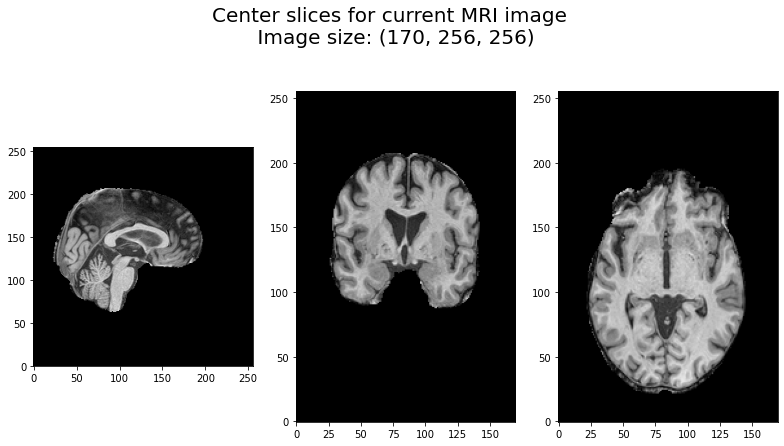

In [8]:
refined_mask_path = '/home/lucasthim1/mmml-alzheimer-diagnosis/src/data/ADNI/Registered/002_S_4225_test/ADNI_002_S_4225_MR_MT1__N3m_Br_20110928092836722_S122881_I258686_masked_basic.nii.gz'
mask_img = nib.load(refined_mask_path).get_fdata()
show_brain_center_slice(mask_img)

## Patient 002_S_4171

### Raw image

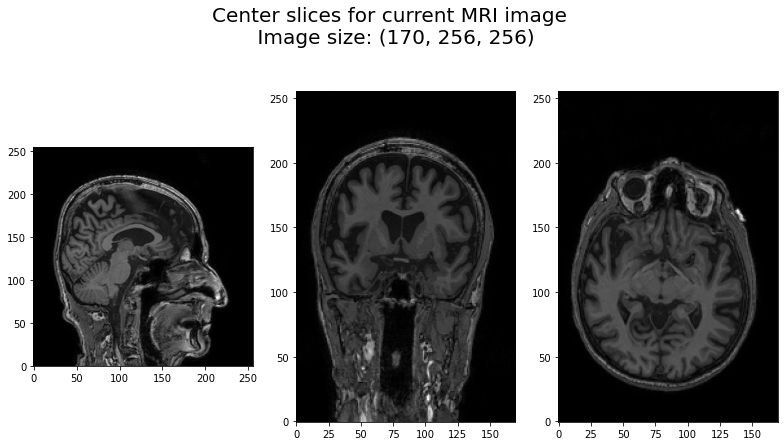

In [36]:
input_path = main_dir + "002_S_4171/MT1__N3m/2011-08-08_17_22_19.0/S118013/ADNI_002_S_4171_MR_MT1__N3m_Br_20110816094410627_S118013_I250649.nii"
img = nib.load(input_path).get_fdata()
show_brain_center_slice(img)

### Affine Registration

In [37]:
input_path = main_dir + "002_S_4171/MT1__N3m/2011-08-08_17_22_19.0/S118013/ADNI_002_S_4171_MR_MT1__N3m_Br_20110816094410627_S118013_I250649.nii"
output_path = main_dir + "/Registered/002_S_4171_affine"
apply_skull_stripping(input_path,output_path,type='affine_refined')

Creating output path... 

Executing Affine Registration... 

Skull stripping started. 
 --------------------------- 

Input Modality: /home/lucasthim1/mmml-alzheimer-diagnosis/src/data/ADNI/002_S_4171/MT1__N3m/2011-08-08_17_22_19.0/S118013/ADNI_002_S_4171_MR_MT1__N3m_Br_20110816094410627_S118013_I250649.nii 

Output Folder : /home/lucasthim1/mmml-alzheimer-diagnosis/src/data/ADNI/Registered/002_S_4171_affine 


Compute basic mask: 
 -----------------

 Deformable tissue registration started 
 -----------------
csf image is saved to: /home/lucasthim1/mmml-alzheimer-diagnosis/src/data/ADNI/Registered/002_S_4171_affine/ADNI_002_S_4171_MR_MT1__N3m_Br_20110816094410627_S118013_I250649_csf.nii.gz
gm image is saved to: /home/lucasthim1/mmml-alzheimer-diagnosis/src/data/ADNI/Registered/002_S_4171_affine/ADNI_002_S_4171_MR_MT1__N3m_Br_20110816094410627_S118013_I250649_gm.nii.gz
wm image is saved to: /home/lucasthim1/mmml-alzheimer-diagnosis/src/data/ADNI/Registered/002_S_4171_affine/ADNI_002_S_

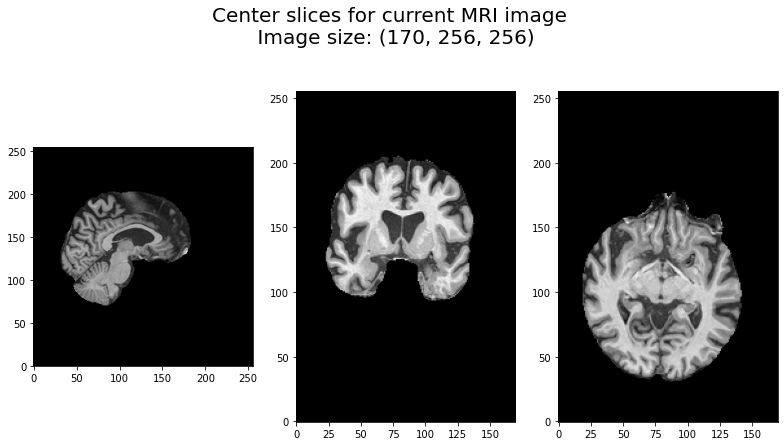

In [40]:
refined_mask_path = '/home/lucasthim1/mmml-alzheimer-diagnosis/src/data/ADNI/Registered/002_S_4171_affine/ADNI_002_S_4171_MR_MT1__N3m_Br_20110816094410627_S118013_I250649_masked.nii.gz'
mask_img = nib.load(refined_mask_path).get_fdata()
show_brain_center_slice(mask_img)

### Rigid Registration

In [38]:
input_path = main_dir + "002_S_4171/MT1__N3m/2011-08-08_17_22_19.0/S118013/ADNI_002_S_4171_MR_MT1__N3m_Br_20110816094410627_S118013_I250649.nii"
output_path = main_dir + "/Registered/002_S_4171_rigid"
apply_skull_stripping(input_path,output_path,type='rigid_refined')

Creating output path... 

Executing Rigid Registration... 

Skull stripping started. 
 --------------------------- 

Input Modality: /home/lucasthim1/mmml-alzheimer-diagnosis/src/data/ADNI/002_S_4171/MT1__N3m/2011-08-08_17_22_19.0/S118013/ADNI_002_S_4171_MR_MT1__N3m_Br_20110816094410627_S118013_I250649.nii 

Output Folder : /home/lucasthim1/mmml-alzheimer-diagnosis/src/data/ADNI/Registered/002_S_4171_rigid 


Compute basic mask: 
 -----------------

Computing refined mask 
 -------------
Applying refined mask 

Results save as /home/lucasthim1/mmml-alzheimer-diagnosis/src/data/ADNI/Registered/002_S_4171_rigid/ADNI_002_S_4171_MR_MT1__N3m_Br_20110816094410627_S118013_I250649_masked.nii.gz 

---------------------------
 Rigid Skull Stripping Finished.
Done! Process took 0.16 min)


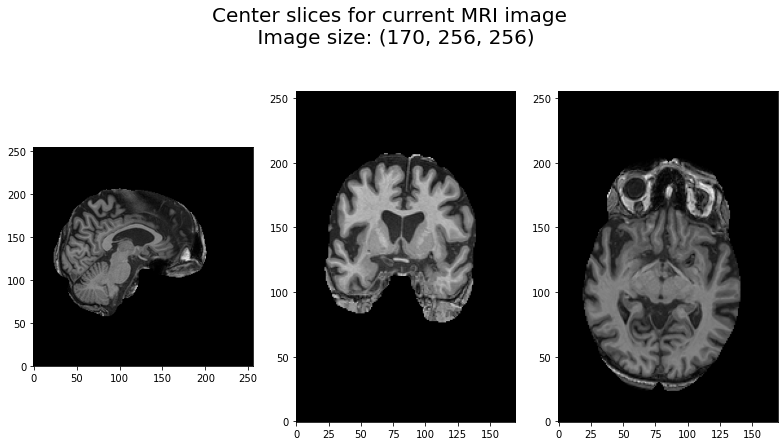

In [42]:
refined_mask_path = '/home/lucasthim1/mmml-alzheimer-diagnosis/src/data/ADNI/Registered/002_S_4171_rigid/ADNI_002_S_4171_MR_MT1__N3m_Br_20110816094410627_S118013_I250649_masked.nii.gz'
mask_img = nib.load(refined_mask_path).get_fdata()
show_brain_center_slice(mask_img)

In [43]:
input_path = main_dir + "002_S_4171/MT1__N3m/2011-08-08_17_22_19.0/S118013/ADNI_002_S_4171_MR_MT1__N3m_Br_20110816094410627_S118013_I250649.nii"
output_path = main_dir + "/Registered/002_S_4171_simple"
apply_skull_stripping(input_path,output_path,type='simple')

Creating output path... 

Executing Simple Rigid Registration... 

Skull stripping started. 
 --------------------------- 

Input Modality: /home/lucasthim1/mmml-alzheimer-diagnosis/src/data/ADNI/002_S_4171/MT1__N3m/2011-08-08_17_22_19.0/S118013/ADNI_002_S_4171_MR_MT1__N3m_Br_20110816094410627_S118013_I250649.nii 

Output Folder : /home/lucasthim1/mmml-alzheimer-diagnosis/src/data/ADNI/Registered/002_S_4171_simple 


Compute basic mask: 
 -----------------
Results save as /home/lucasthim1/mmml-alzheimer-diagnosis/src/data/ADNI/Registered/002_S_4171_simple/ADNI_002_S_4171_MR_MT1__N3m_Br_20110816094410627_S118013_I250649_masked_basic.nii.gz 

---------------------------
Skull Stripping Finished.
Done! Process took 0.15 min)


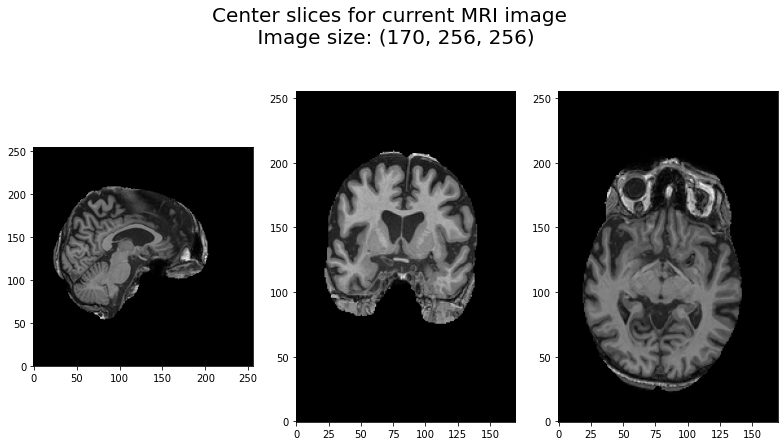

In [44]:
refined_mask_path = '/home/lucasthim1/mmml-alzheimer-diagnosis/src/data/ADNI/Registered/002_S_4171_simple/ADNI_002_S_4171_MR_MT1__N3m_Br_20110816094410627_S118013_I250649_masked_basic.nii.gz'
mask_img = nib.load(refined_mask_path).get_fdata()
show_brain_center_slice(mask_img)

For now, it looks like the affine registration removes nervous and eye tissues better from the image. 

Try the eye and face mask from the template I downloaded 

In [9]:
main_dir

'/home/lucasthim1/mmml-alzheimer-diagnosis/src/data/ADNI/'

In [ ]:
import ants
import numpy as np

img1 = ants.image_read( ants.get_ants_data('r16') )
img2 = ants.image_read( ants.get_ants_data('r27') )
img3 = ants.image_read( ants.get_ants_data('r64') )

In [23]:
os.listdir('/home/lucasthim1/alzheimer_bucket/SAMPLE_UPLOAD_GCLOUD/941_S_5193/MT1__GradWarp__N3m/2013-05-29_12_07_08.0/S190909')

['ADNI_941_S_5193_MR_MT1__GradWarp__N3m_Br_20130607141303545_S190909_I375627.nii']

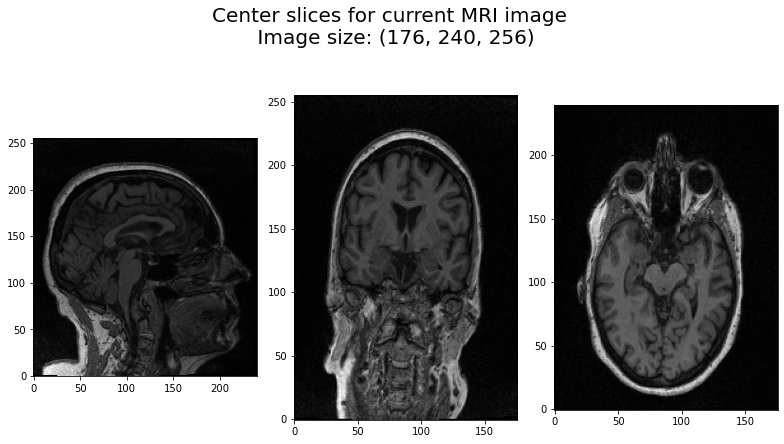

In [24]:
main_dir = '/home/lucasthim1/alzheimer_bucket/SAMPLE_UPLOAD_GCLOUD'
input_path = '/home/lucasthim1/alzheimer_bucket/SAMPLE_UPLOAD_GCLOUD/941_S_5193/MT1__GradWarp__N3m/2013-05-29_12_07_08.0/S190909/ADNI_941_S_5193_MR_MT1__GradWarp__N3m_Br_20130607141303545_S190909_I375627.nii'
img = nib.load(input_path).get_fdata()
show_brain_center_slice(img)

## Checking Registration Atlas

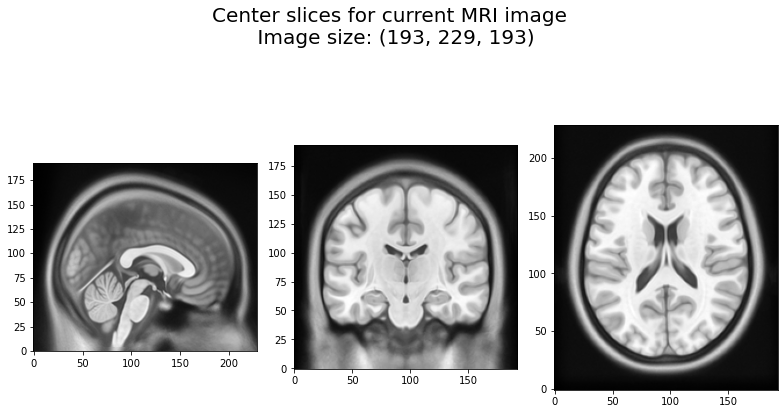

In [72]:
atlas = '/home/lucasthim1/mmml-alzheimer-diagnosis/src/playground/utils/s3/Atlas/atlas_t1.nii'
atlas_img = nib.load(atlas).get_fdata()
show_brain_center_slice(atlas_img)

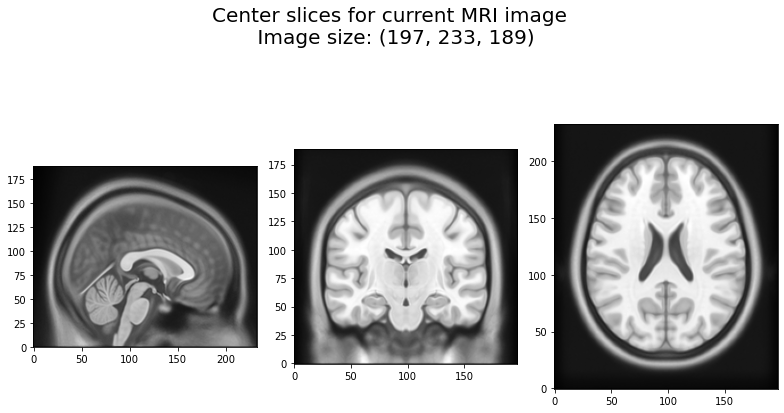

In [80]:
atlas_dir = '/home/lucasthim1//alzheimer_bucket/atlas/ICBM152_2009a_nonlinear_symmetric/'
# os.listdir(atlas_dir)
atlas =atlas_dir + 'mni_icbm152_t1_tal_nlin_sym_09a.nii'
atlas_img = nib.load(atlas).get_fdata()
show_brain_center_slice(atlas_img)